In [313]:
import os
import cv2
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imgaug.augmenters as iaa
from tensorflow.keras.models import load_model
from itertools import chain
from pathlib import Path
from skimage.io import imread, imshow
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Graphing
import seaborn as sns

# Check for GPU and allocate a fixed amount of GPU mem
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
    print(e)

In [314]:
# Base file path for data
data_path = Path('C://Users//Gabriel//Desktop//CS3244//PneumoniaCNN//chest_xray')

# File path for training images
train_path = data_path / 'train'

# File path for testing images
test_path = data_path / 'test'

Normal
Img Shape: (744, 1224)


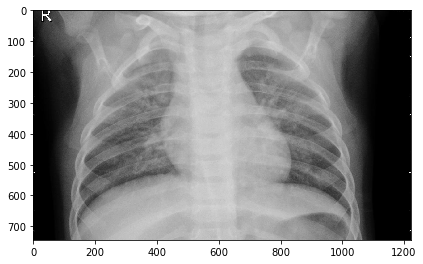

In [315]:
from skimage.exposure import equalize_adapthist, equalize_hist

print("Normal")
print("Img Shape: " + str(sample_image.shape))
imshow(sample_image)

CLAHE
Img Shape: (744, 1224)


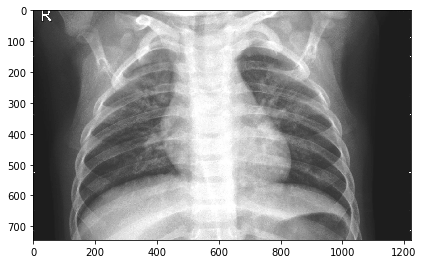

In [316]:
print("CLAHE")
print("Img Shape: " + str(enhanced_sample_image.shape))
enhanced_sample_image = equalize_hist(sample_image)
imshow(enhanced_sample_image)

In [317]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               brightness_range=[0.8,1.2]) # Vary brightness between range +-

    # fill_mode='nearest')

image_shape = (112, 112, 1)

# early_stop = EarlyStopping(monitor='val_loss',patience=2)

batch_size = 16

In [318]:
sample_image_path = test_path / 'PNEUMONIA' / 'person76_virus_138.jpeg'

sample_image = imread(sample_image_path)

sample_image.shape

(744, 1224)

In [319]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [320]:
train_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [321]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, SeparableConv2D, AveragePooling2D, DepthwiseConv2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [322]:
model_input = Input(shape=image_shape)

conv_layer_1 = Conv2D(16, (3,3), activation='relu', padding='same')(model_input)
conv_layer_1 = Conv2D(32, (3,3), activation='relu')(conv_layer_1)
conv_layer_1 = BatchNormalization()(conv_layer_1)
pooling_layer_1 = MaxPooling2D((2,2))(conv_layer_1)

# conv_layer_2 = SeperableConv2D(128, (3,3), activation='relu', padding='same')(pooling_layer_1)
# conv_layer_2 = BatchNormalization()(conv_layer_2)
# pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)

conv_layer_2 = Conv2D(64, (3,3), activation='relu')(pooling_layer_1)
conv_layer_2 = Conv2D(96, (3,3), activation='relu')(conv_layer_2)
conv_layer_2 = BatchNormalization()(conv_layer_2)
pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)

# # Inception v2
# conv_layer_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pooling_layer_1)
# conv_layer_2 = BatchNormalization()(conv_layer_2)
# pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)
# pooling_layer_2 = Conv2D(128, (1,1), activation='relu')(pooling_layer_2)

x1 = Conv2D(64, (1,1), activation='relu')(pooling_layer_2)

x2 = Conv2D(48, (1,1), activation='relu')(pooling_layer_2)
x2 = Conv2D(64, (3,3), activation='relu', padding='same')(x2)

x3 = Conv2D(32, (1,1), activation='relu')(pooling_layer_2)
x3 = Conv2D(48, (5,5), activation='relu', padding='same')(x3)

x4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(pooling_layer_2)
x4 = Conv2D(80, (1,1), activation='relu')(x4)

inception_layer = concatenate([x1, x2, x3, x4])

# # Inception v2

model = DepthwiseConv2D((3,3), activation='relu')(inception_layer)

model = SeparableConv2D(128, (3,3), activation='relu')(model)

model = BatchNormalization()(model)

model = Conv2D(80, (1,1), activation='relu')(model)

model = BatchNormalization()(model)

model = MaxPooling2D((2,2))(model)

# model = Conv2D(64, (1,1), activation='relu')(inception_layer)

model = Flatten()(model)

model = Dense(128, activation='relu')(model)

model = Dropout(0.5)(model)

model_output = Dense(1, activation='sigmoid')(model)

model = Model(inputs=model_input, outputs=model_output)

model.compile(loss='binary_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])


In [323]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 112, 112, 1) 0                                            
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 112, 112, 16) 160         input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 110, 110, 32) 4640        conv2d_206[0][0]                 
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 110, 110, 32) 128         conv2d_207[0][0]                 
___________________________________________________________________________________________

In [324]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras import backend as K

class printLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(K.eval(self.model.optimizer.lr))

In [325]:
results = model.fit(train_image_gen,epochs=25,
                              validation_data=test_image_gen,
                               callbacks=[ReduceLROnPlateau(), ModelCheckpoint('checkpoint.h5',save_best_only=True)])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 326 steps, validate for 39 steps
Epoch 1/25
326/326 [==============================] - 159s 488ms/step - loss: 0.6327 - accuracy: 0.8284 - val_loss: 1.7903 - val_accuracy: 0.6250
Epoch 2/25
326/326 [==============================] - 157s 483ms/step - loss: 0.3733 - accuracy: 0.8763 - val_loss: 4.3360 - val_accuracy: 0.6266
Epoch 3/25
326/326 [==============================] - 158s 484ms/step - loss: 0.3169 - accuracy: 0.9053 - val_loss: 4.9068 - val_accuracy: 0.6763
Epoch 4/25
326/326 [==============================] - 157s 483ms/step - loss: 0.2766 - accuracy: 0.9132 - val_loss: 1.1897 - val_accuracy: 0.8253
Epoch 5/25
326/326 [==============================] - 163s 500ms/step - loss: 0.2537 - accuracy: 0.9133 - val_loss: 5.5818 - val_accuracy: 0.6330
Epoch 6/25
326/326 [==============================] - 157s 482ms/step - loss: 0.2342 - accuracy: 0.9233 - val_loss: 0.4672 - val_accuracy: 0.8381
Epoch 7/25
326/326 [===========

In [326]:
from tensorflow.keras.models import load_model
model.save('curr_model.h5')

In [327]:
losses = pd.DataFrame(model.history.history)

In [328]:
metric_names = model.metrics_names
metric_values = model.evaluate_generator(test_image_gen)


for i in range(len(model.metrics_names)):
    print("{name:s}: {value:.5f}".format(name=metric_names[i], value=metric_values[i]))

  ...
    to  
  ['...']
loss: 0.76005
accuracy: 0.83013


In [329]:
from tensorflow.keras.preprocessing import image
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [330]:
pred_probabilities

array([[4.3292186e-01],
       [3.8649136e-01],
       [6.3877814e-02],
       [3.3591622e-01],
       [2.5832847e-01],
       [4.1369195e-03],
       [8.9963049e-01],
       [3.3678424e-01],
       [3.6135375e-02],
       [3.2791410e-02],
       [2.2935344e-02],
       [9.3214750e-01],
       [3.6724391e-03],
       [8.2098347e-01],
       [9.9061054e-01],
       [5.1400483e-01],
       [9.9767679e-01],
       [1.2981177e-02],
       [2.3478546e-04],
       [2.9559884e-05],
       [2.1908420e-01],
       [3.1021720e-04],
       [6.4239167e-03],
       [6.7375023e-03],
       [9.9994946e-01],
       [5.2194571e-01],
       [3.9288406e-03],
       [1.9361628e-03],
       [7.2216666e-01],
       [9.8597383e-01],
       [4.7152019e-01],
       [9.6543634e-01],
       [1.2519498e-03],
       [3.8200680e-03],
       [8.8580811e-01],
       [6.3414513e-03],
       [5.6636315e-03],
       [2.2229657e-01],
       [5.7114277e-02],
       [4.4006345e-05],
       [9.8461366e-01],
       [1.057963

In [331]:
predictions = pred_probabilities > 0.5

In [332]:
# Only for binary classification
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.98      0.56      0.71       234
           1       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



<Figure size 432x288 with 0 Axes>

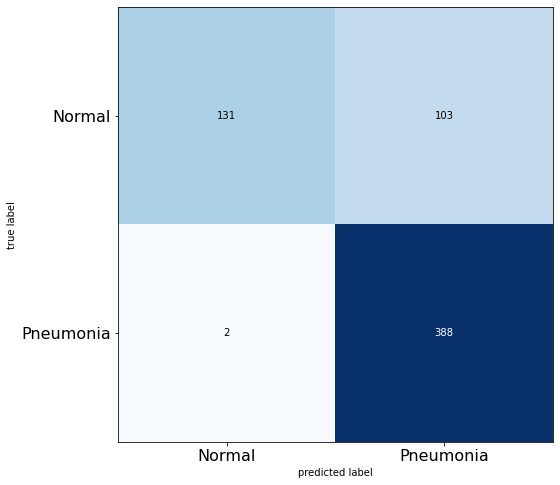

In [333]:
cm  = confusion_matrix(test_image_gen.classes, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()